In [1]:
import warnings
import numpy as np
import pandas as pd
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

In [2]:
read_file = pd.read_csv('dataset/new_train_dataset_1_5', delimiter=',', header=None)
train_dataset = read_file.iloc[:,:].values

In [3]:
read_file = pd.read_csv('dataset/new_validation_dataset_1_5', delimiter=',', header=None)
validation_dataset = read_file.iloc[:,:].values

In [5]:
embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')

In [6]:
def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,9 - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [7]:
left_train = []
rigth_train = []
label = []

for articleID, articleTitle, tableID, tableTitle, match in tqdm(train_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 9:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_train.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:9]]
        left_train.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 9:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_train.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:9]]
        rigth_train.append(embedding2)
    
    
    label.append(match)

100%|██████████| 316183/316183 [00:55<00:00, 5678.56it/s]


In [8]:
left_train = np.array(left_train)
rigth_train = np.array(rigth_train)
label_train = np.array(label)

In [9]:
left_train.shape

(316183, 9, 300)

In [10]:
left_validation = []
rigth_validation = []
label_validation = []

for articleID, articleTitle, tableID, tableTitle, match in tqdm(validation_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 9:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_validation.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:9]]
        left_validation.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 9:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_validation.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:9]]
        rigth_validation.append(embedding2)
    
    
    label_validation.append(match)

100%|██████████| 16623/16623 [00:02<00:00, 5971.35it/s]


In [11]:
left_validation = np.array(left_validation)
rigth_validation = np.array(rigth_validation)
label_validation = np.array(label_validation)

In [12]:
def coattention_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)

    #transpose_affinity = tf.transpose(affinity, perm=[0, 2, 1])
    
    #row_normalized = tf.nn.softmax(affinity, axis=1)
    
    #column_normalized = tf.nn.softmax(transpose_affinity, axis=1)
    
    #context_vector = tf.matmul(row_normalized,document)
    
    #concatenate_context_query = tf.concat([context_vector,query],axis=-1)
     
    #context_document = tf.matmul(column_normalized,concatenate_context_query)
    
    #co_attention = tf.concat([document,context_document],axis=-1)
    
    return affinity

In [13]:
def attention_model():
    
    query = tf.keras.Input(shape=(9,300), dtype='float32')
    document = tf.keras.Input(shape=(9,300), dtype='float32')
    
    encodding_query = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(query)
    encodding_document = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(document)
    
    co_attention = coattention_method(encodding_query,encodding_document)
    #co_attention = coattention_method(query,document)
    
    #sequence_context = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(co_attention)
    
    #flatten = tf.keras.layers.Flatten()(sequence_context)
    flatten = tf.keras.layers.Flatten()(co_attention)
    
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(flatten)
    
    model = tf.keras.Model(inputs=[query,document],outputs=prediction)
    
    return model

In [14]:
model = attention_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='test.png')

In [15]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('attention.h5', monitor='val_acc',verbose=1, save_the_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [16]:
history = model.fit([left_train, rigth_train], label_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=([left_validation, rigth_validation], label_validation))
          #callbacks=callbacks_list)

Train on 316183 samples, validate on 16623 samples
Epoch 1/10
316183/316183 [==============================] - 95s 301us/sample - loss: 0.1939 - accuracy: 0.9254 - val_loss: 0.1604 - val_accuracy: 0.9368
Epoch 2/10
316183/316183 [==============================] - 90s 284us/sample - loss: 0.1216 - accuracy: 0.9543 - val_loss: 0.1359 - val_accuracy: 0.9486
Epoch 3/10
316183/316183 [==============================] - 90s 284us/sample - loss: 0.0806 - accuracy: 0.9705 - val_loss: 0.1445 - val_accuracy: 0.9509
Epoch 4/10
316183/316183 [==============================] - 90s 285us/sample - loss: 0.0529 - accuracy: 0.9810 - val_loss: 0.1387 - val_accuracy: 0.9549
Epoch 5/10
316183/316183 [==============================] - 90s 284us/sample - loss: 0.0336 - accuracy: 0.9879 - val_loss: 0.1626 - val_accuracy: 0.9548
Epoch 6/10
316183/316183 [==============================] - 90s 284us/sample - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.1666 - val_accuracy: 0.9591
Epoch 7/10
316183/316183 [=====

In [17]:
model.save('attention_model2.h5')

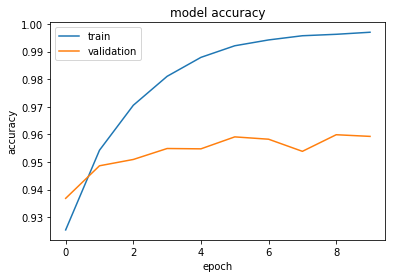

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

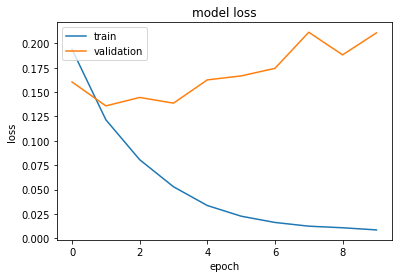

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
y_prob = model.predict([left_validation,rigth_validation])

In [21]:
y_prob = (y_prob > 0.5).astype(np.int)

In [ ]:
y_prob[0:10]

In [22]:
accuracy_score(label_validation, y_prob)

0.9592732960356133

In [23]:
classes=[0,1]
con_mat = tf.math.confusion_matrix(labels=label_validation, predictions=y_prob).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

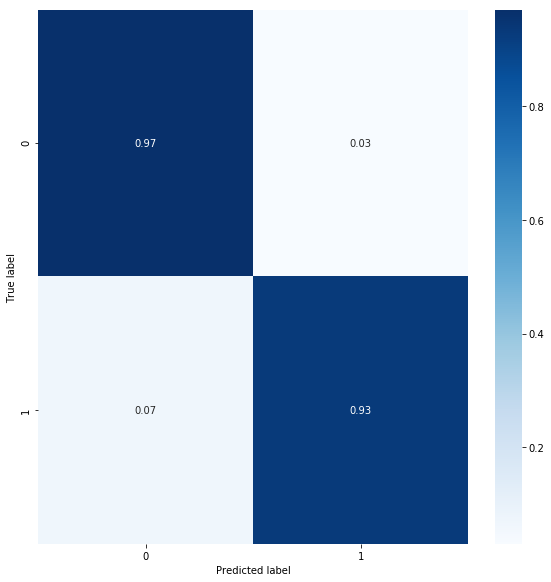

In [24]:
import seaborn as sns;
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import gensim as gs
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
indexing_tables = Elasticsearch()
import tensorflow as tf

In [26]:
indexing_tables.indices.close(index='tables')
indexing_tables.indices.put_settings(index='tables', body={"index": {"similarity": {"default": {"type": "classic"}}}})
indexing_tables.indices.open(index='tables')

{'acknowledged': True, 'shards_acknowledged': True}

In [27]:
raw_articles = pd.read_csv('dataset/test_dataset', delimiter=',', header=None)
data_articles = raw_articles.iloc[:,:].values

In [28]:
def search_indexing(query):
    
    result= indexing_tables.search(
        index="tables", 
        body = {
        "_source": ["tablePgID","tablePgTitle"],
        "from" : 0,
        "size" : 1000,
        "query": {
            "multi_match":{
              "type": "most_fields",
              "query":    query, 
              #"fields": ["tablePgTitle"]
              "fields": ["tablePgTitle","tableHeader","tableBody"]
            }
        }
    })
    
    return result

In [32]:
def get_accuracy(ID_goal,ranked_tables_ID):
    
    accuracy = 0
    
    for table_ID in ranked_tables_ID:
        
        if table_ID == ID_goal:
    
            accuracy = 1
            break

    return accuracy

In [30]:
def search_index(article_title):
    
    tables_index = []

    result_index = search_indexing(article_title)
        
    for hit in result_index['hits']['hits']:
    
        table_ID = hit['_source']['tablePgID']
        
        table_page_title = hit['_source']['tablePgTitle']
    
        tables_index.append([table_ID,table_page_title])
    
    return tables_index

In [33]:
def create_embedding1(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < 9:
        
        embedding = embedding_model.wv[value]
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:9]]
        
        return embedding

In [34]:
ranking_model = model

In [50]:
TOP_K = 10
accuracy = []

for article_ID, article_title, article_text, meta_description, summary, keywords, meta_keywords, tags in tqdm(data_articles[0:1000]):
    
    embedding_left = []
    embedding_rigth = []
    ranked_tables_model = []
        
    ranked_tables_index = search_index(article_title)
        
    article_title_embedding = create_embedding1(article_title)
        
    for table_ID, table_title in (ranked_tables_index):
        
        table_title_embedding = create_embedding1(str(table_title))
            
        embedding_left.append(article_title_embedding)
            
        embedding_rigth.append(table_title_embedding)
    
    embedding_left = np.array(embedding_left)
    embedding_rigth = np.array(embedding_rigth)
    
    table_ranking_model = ranking_model.predict([embedding_left,embedding_rigth])
    
    for i in range(0,len(table_ranking_model)):
        
        ranked_tables_model.append([ranked_tables_index[i][0],ranked_tables_index[i][1],table_ranking_model[i][0]]) 
        
    data_frame = pd.DataFrame(ranked_tables_model, columns = ['table_ID', 'table_title','table_ranking']) 
    data_frame_sorting = data_frame.sort_values('table_ranking', ascending=False)
    final_ranked_tables = data_frame_sorting.iloc[0:TOP_K,0:1].values
           
    accuracy.append(get_accuracy(article_ID, final_ranked_tables))
    #print(accuracy)
        
print(str(round(np.mean(accuracy),4))+" (±) "+str(round(np.std(accuracy),4)))



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:17<4:50:12, 17.43s/it]

  0%|          | 2/1000 [00:30<4:27:19, 16.07s/it]

  0%|          | 3/1000 [00:59<5:32:07, 19.99s/it]

ConnectionTimeout: ConnectionTimeout caused by - ReadTimeoutError(HTTPConnectionPool(host='localhost', port=9200): Read timed out. (read timeout=10))

In [44]:
article_title

'the official new zealand music chart'

article_ID

In [47]:
article_ID

17674669

In [45]:
data_frame[0:100]

,table_ID,table_title,table_ranking
0,2376836,new zealand open,9.999319e-01
1,1268944,archbishop new zealand,9.747264e-01
2,35771399,official streaming chart,9.999932e-01
3,470246,jonathan hunt new zealand politician,1.123548e-05
4,37403485,new zealand music awards,2.997727e-01
5,21031,mike moore new zealand politician,1.314822e-02
6,597799,john banks new zealand politician,1.247361e-02
7,35921853,official classical singles chart,9.997059e-01
8,35262372,official record store chart,9.999721e-01
9,20740561,air new zealand cup,7.987022e-06


In [46]:
data_frame_sorting[0:100]

,table_ID,table_title,table_ranking
779,19831266,sic nesses,1.0
583,1075901,murray mccully,1.0
417,4703697,cathcart wason,1.0
574,1051984,clive matthewson,1.0
575,4745651,harry atmore,1.0
412,1181419,roger mcclay,1.0
223,1070117,harry duynhoven,1.0
408,1097666,judy keall,1.0
484,599955,gerry brownlee,1.0
580,1072927,richard worth,1.0


In [17]:
cont = 0
for i in train_dataset:
    if i[4] == 1:
        cont = cont + 1
print(cont)

25181
